In [38]:
%pip install numpy
%pip install opencv-python
%pip install matplotlib
%pip install scipy
%pip install numba



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [39]:
import math
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from numba import njit,prange
from scipy.fft._pocketfft.basic import fft2, ifft2
from scipy.signal import gaussian
from scipy.signal.signaltools import wiener


In [40]:
def psnr(im1, im2):
	mse = np.mean((im1-im2)**2)
	if mse==0:
		return 100
	return 20*np.log10(1/np.sqrt(mse))
@njit
def Level_A(arr,i,j,ker,ker_max):
	k=ker//2
	kernel = arr[i-k:i+k+1,j-k:j+k+1]
	Zmin = np.min(kernel)
	Zmed = np.median(kernel)
	Zmax = np.max(kernel)

	A1 = Zmed - Zmin
	A2 = Zmed - Zmax

	if A1 > 0 and A2 < 0:
		return Level_B(kernel, Zmin, Zmed, Zmax)
	else:
		ker+= 2 
		if ker <= ker_max:
			return Level_A(arr,i,j,ker,ker_max)
		else:
			return Zmed

@njit
def Level_B(kernel, Zmin, Zmed, Zmax):
	row,col = kernel.shape
	Zxy = kernel[row//2,col//2]
	B1 = Zxy - Zmin
	B2 = Zxy - Zmax
	if B1 > 0 and B2 < 0 :
		return Zxy
	else:
		return Zmed

def noisy(noise_typ,image):
	if noise_typ == "gauss":
		var = 0.01
		std = math.sqrt(var)	
		gauss=np.random.normal(0,std,np.shape(image))		
		noisy=image+gauss
			
		return noisy	
	elif noise_typ == "s&p":
		s_vs_p = 0.5
		amount = 0.02
		out = np.copy(image)
		# Salt mode
		num_salt = np.ceil(amount*image.size*s_vs_p)
		coords = [np.random.randint(0,i-1,int(num_salt)) for i in image.shape]
		out[tuple(coords)] = 1
		
		# Pepper mode
		num_pepper = np.ceil(amount*image.size*(1-s_vs_p))
		coords = [np.random.randint(0,i-1,int(num_pepper)) for i in image.shape]
		out[tuple(coords)] = 0	
		return out

	elif noise_typ =="speckle":
		var = 0.01
		std = var**0.5	
		gauss = np.random.normal(0,std,np.shape(image))     
		noisy = image+image*gauss
		return noisy

	elif noise_typ == "poisson":
		vals = len(np.unique(image))
		vals = 2**np.ceil(np.log2(vals))
		noisy = np.random.poisson(image*vals)/float(vals)
			
		return noisy

def filter(filter_typ,imgN):
	if filter_typ == "mean":
		# Mean Filter
		row,col=imgN.shape
		res1=np.copy(imgN)
		ker=3
		k=ker//2
		arr=np.pad(imgN, k, mode='constant')
		for i in range(k,row+k):
			for j in range(k,col+k):		
				ker_mat = arr[i-k:i+k+1,j-k:j+k+1].flatten().tolist()
				t = np.sum(ker_mat)        
				res1[i-k,j-k] = t/len(ker_mat)
		return res1

	elif filter_typ == "median":
		# Median Filter
		row,col=imgN.shape
		res1=np.copy(imgN)
		ker=3
		k=ker//2
		arr=np.pad(imgN, k, mode='constant')
		for i in range(k,row+k):
			for j in range(k,col+k):
				ker_matrix = arr[i-k:i+k+1,j-k:j+k+1].flatten().tolist()
				temp=sorted(ker_matrix)		         
				res1[i-k,j-k] = np.median(temp)
		return res1
	elif filter_typ == "gaussian":
		sigma=1
		row,col=imgN.shape
		res1=np.copy(imgN)
		ker=5
		k=ker//2
		arr=np.pad(imgN, k, mode='constant')
		ker_mat=np.zeros((ker,ker))
		for i in range(-k,k+1):
			for j in range(-k,k+1):		         
				ker_mat[i+k,j+k] = np.exp(-((i)**2+(j)**2)/(2*sigma**2))/math.sqrt((2*math.pi*(sigma**2)))
		ker_mat=ker_mat/np.sum(ker_mat)
		
		for i in range(k,row+k):
			for j in range(k,col+k):
				temp=arr[i-k:i+k+1,j-k:j+k+1].flatten()*(ker_mat.flatten())
				res1[i-k,j-k] = np.sum(temp)		
		
		return res1	
	elif filter_typ == "bilateral":
		sigma=1
		sigmaI=1
		row,col=imgN.shape
		res1=np.copy(imgN)
		ker=7
		k=ker//2
		arr=np.pad(imgN, k, mode='constant')
		ker_mat=np.zeros((ker,ker))
		for i in range(0,ker):
			for j in range(0,ker):	
				x=math.sqrt(abs(i-k)**2 + abs(j-k)**2)	         
				ker_mat[i,j] = np.exp(-(x**2)/(2*sigma**2))/math.sqrt((2*math.pi*(sigma**2)))	
		for i in range(k,row+k):
			for j in range(k,col+k):
				imgq=arr[i-k:i+k+1,j-k:j+k+1]
				imgI=arr[i,j]-arr[i-k:i+k+1,j-k:j+k+1]
				imgIG= np.exp(-(imgI**2)/(2*sigmaI**2))/math.sqrt((2*math.pi*(sigmaI**2)))
				weights = np.multiply(ker_mat, imgIG)
				res1[i-k,j-k]=np.sum(np.multiply(imgq, weights))/ np.sum(weights)	
		imgN = imgN.astype(np.float32)	
					
		return res1	
		
	elif filter_typ == "wiener":
		ker=3
		sigma=ker/3
		h = gaussian(ker, sigma).reshape(ker, 1)
		h = np.dot(h, h.transpose())
		h /= np.sum(h)
		nsr=0.1
		Hk = fft2(h,s=imgN.shape)
		kernel = np.conj(Hk)/(np.abs(Hk)**2+nsr)
		dummy = fft2(imgN)*kernel
		res1 = np.abs(ifft2(dummy))
		res1=wiener(imgN,ker,nsr)
		return res1

	elif filter_typ =="adaptiveLocal":
		row,col=imgN.shape
		res1=np.copy(imgN)
		ker=5
		k=ker//2		
		varNoi=0
		varLoc=np.copy(imgN)
		arr=np.pad(imgN, k, mode='constant')					
		for i in range(k,row+k):
			for j in range(k,col+k):
				ker_mat = arr[i-k:i+k+1,j-k:j+k+1].flatten().tolist()
				varLoc[i-k,j-k]=np.var(ker_mat)
				meanLoc=np.mean(ker_mat)	
				varNoi=varNoi+varLoc[i-k,j-k]/(row*col)	         
				res1[i-k,j-k] = (imgN[i-k,j-k]-meanLoc)	
		varLoc=np.maximum(varLoc,varNoi)
		res1 = imgN-(varNoi/varLoc)*res1			
		return res1

	elif filter_typ == "adaptiveMedian":
		# Adaptive Median Filter
		row,col = imgN.shape
		res1=np.copy(imgN)
		ker_max=7
		k_max = ker_max//2
		arr=np.pad(imgN, k_max, mode='constant')
		ker=3
		for i in prange(k_max,k_max+row):
			for j in range(k_max,k_max+col):
				res1[i-k_max,j-k_max] = Level_A(arr,i,j,ker,ker_max)
		return res1

def showImg(imgO,x,y,i):
	plt.figure(figsize=(8,8))
	if imgO.ndim==2:
		imgN=noisy(x[i],imgO)
		plt.subplot(1,2,1)
		plt.imshow(imgO,cmap='gray')
		plt.title('Original')
		
		txt="psnr="+str(psnr(imgN,imgO))
		plt.subplot(1,2,2)
		plt.imshow(imgN,cmap='gray')
		plt.title('%s noise'%x[i])
		plt.xlabel(txt)
		print("The signal to noise ratio of image with",x[i],"noise is" ,psnr(imgN,imgO))
		plt.figure(figsize=(14,14))
		for j in range(len(y)):
			res=filter(y[j],imgN)
			txt="psnr="+str(psnr(res,imgO))
			plt.subplot(3,4,j+1)
			plt.imshow(res,cmap='gray')
			plt.title('%s'%y[j])
				
			plt.xlabel(txt)
			print("The signal to noise ratio of denoised image using",y[j],"filter is",psnr(res,imgO))
	if imgO.ndim==3:
		res=np.copy(imgO)
		row,col,ch=imgO.shape
		imgN=noisy(x[i],imgO)
		plt.subplot(1,2,1)
		plt.imshow(imgO)
		plt.title('Original')
		
		txt="psnr="+str(psnr(imgN,imgO))
		plt.subplot(1,2,2)
		plt.imshow(imgN)
		plt.title('%s noise'%x[i])
		plt.xlabel(txt)
		print("The signal to noise ratio of image with",x[i],"noise is",psnr(imgN,imgO))
		plt.figure(figsize=(14,14))
		for j in range(len(y)):
			for i in range(ch):	
				res[:,:,i]=filter(y[j],imgN[:,:,i])
			txt="psnr="+str(psnr(res,imgO))
			plt.subplot(3,4,j+1)
			plt.imshow(res)
			plt.title('%s'%y[j])
				
			plt.xlabel(txt)
			print("The signal to noise ratio of denoised image using",y[j],"filter is",psnr(res,imgO))
	plt.show()
	return

In [41]:
imgOr=plt.imread('img5.png')
imgOr=cv2.cvtColor(imgOr, cv2.COLOR_BGR2GRAY)
blur=cv2.blur(imgOr,(7,7))

imgOr = cv2.normalize(imgOr, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
imgOr = imgOr.astype(np.float32)

x=['s&p','gauss','speckle','poisson']
y=['mean','median','gaussian','bilateral','wiener','adaptiveLocal','adaptiveMedian']


The signal to noise ratio of image with s&p noise is 21.126272977612594
The signal to noise ratio of denoised image using mean filter is 24.655606823924174
The signal to noise ratio of denoised image using median filter is 28.890940250481883
The signal to noise ratio of denoised image using gaussian filter is 24.744531020966043
The signal to noise ratio of denoised image using bilateral filter is 25.456055271343793
The signal to noise ratio of denoised image using wiener filter is 25.34327908795039
The signal to noise ratio of denoised image using adaptiveLocal filter is 23.84328377814368
The signal to noise ratio of denoised image using adaptiveMedian filter is 31.989778943144024


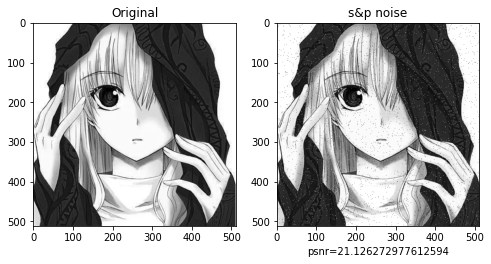

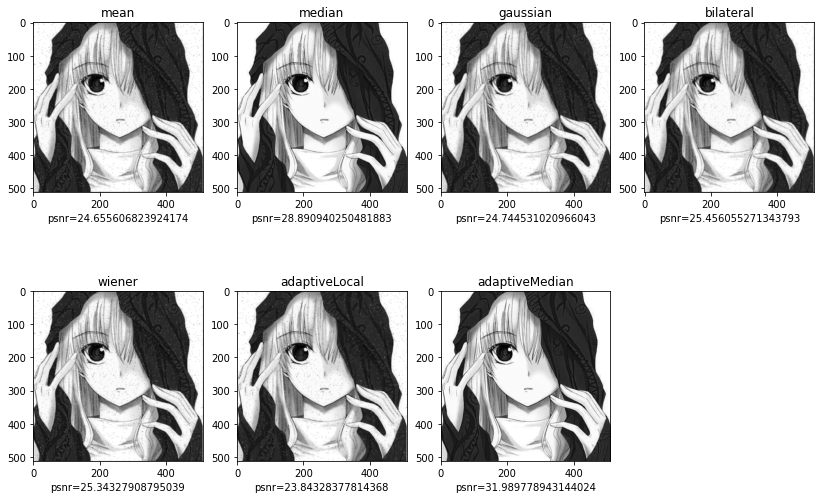

In [42]:
showImg(imgOr,x,y,0)

The signal to noise ratio of image with gauss noise is 19.986100944575078
The signal to noise ratio of denoised image using mean filter is 24.47925583075694
The signal to noise ratio of denoised image using median filter is 24.715603158027648
The signal to noise ratio of denoised image using gaussian filter is 24.667222783477772
The signal to noise ratio of denoised image using bilateral filter is 25.293913251903206
The signal to noise ratio of denoised image using wiener filter is 25.184294340300713
The signal to noise ratio of denoised image using adaptiveLocal filter is 25.81700951299625
The signal to noise ratio of denoised image using adaptiveMedian filter is 22.417385675369715


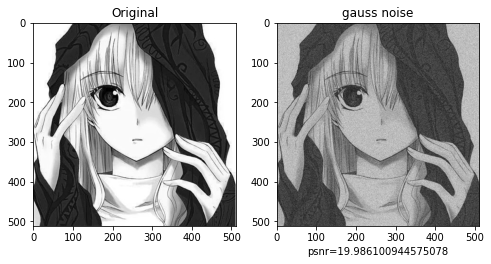

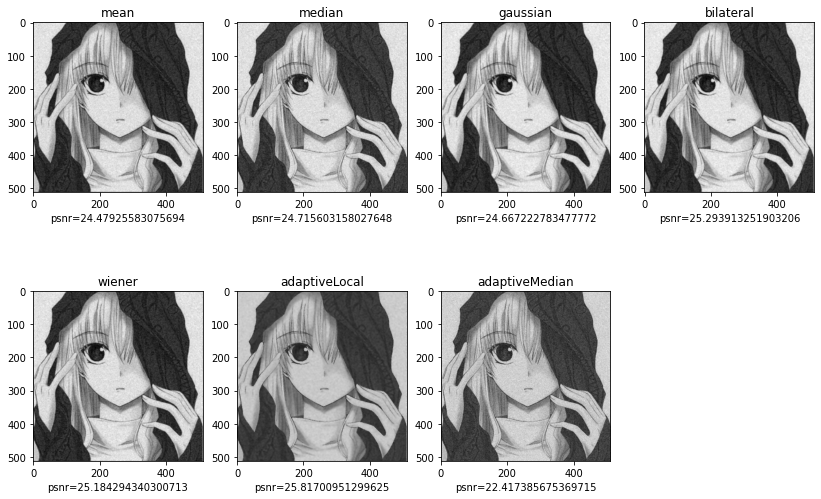

In [43]:
showImg(imgOr,x,y,1)


The signal to noise ratio of image with speckle noise is 23.22456550649496
The signal to noise ratio of denoised image using mean filter is 25.271361333644503
The signal to noise ratio of denoised image using median filter is 26.403654800044222
The signal to noise ratio of denoised image using gaussian filter is 25.274536093743684
The signal to noise ratio of denoised image using bilateral filter is 25.981030502916802
The signal to noise ratio of denoised image using wiener filter is 26.11364807359331
The signal to noise ratio of denoised image using adaptiveLocal filter is 27.15190649234831
The signal to noise ratio of denoised image using adaptiveMedian filter is 25.269380026407493


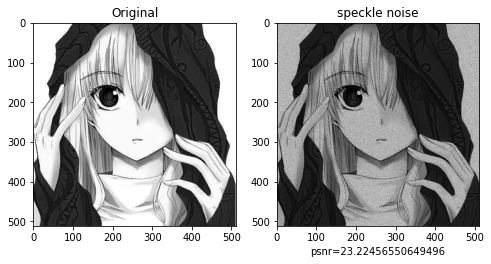

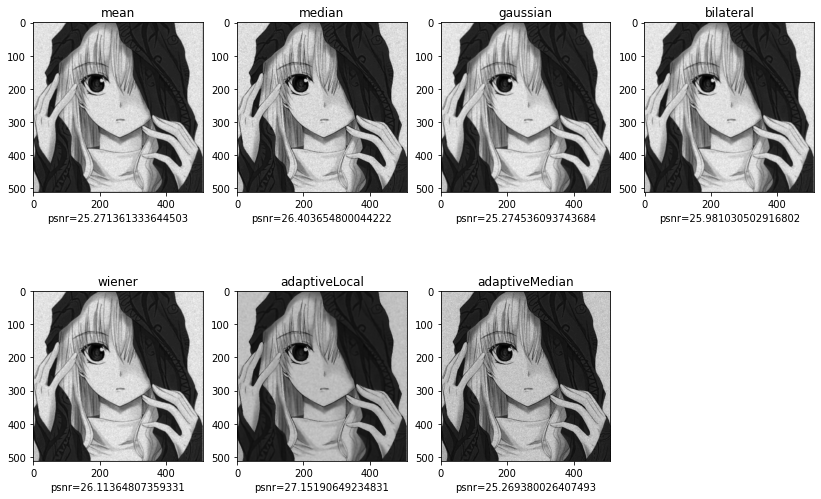

In [44]:
showImg(imgOr,x,y,2)


The signal to noise ratio of image with poisson noise is 53.51947407462351
The signal to noise ratio of denoised image using mean filter is 26.137326562798748
The signal to noise ratio of denoised image using median filter is 29.156174061699197
The signal to noise ratio of denoised image using gaussian filter is 25.903879700945538
The signal to noise ratio of denoised image using bilateral filter is 26.71497673280966
The signal to noise ratio of denoised image using wiener filter is 27.211829939656127
The signal to noise ratio of denoised image using adaptiveLocal filter is 29.400693312260447
The signal to noise ratio of denoised image using adaptiveMedian filter is 34.332068419987436


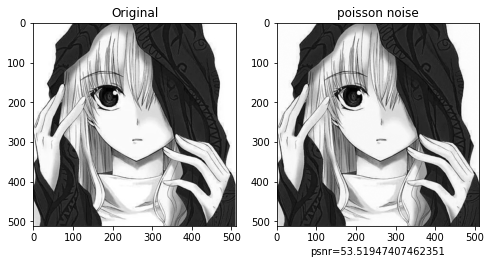

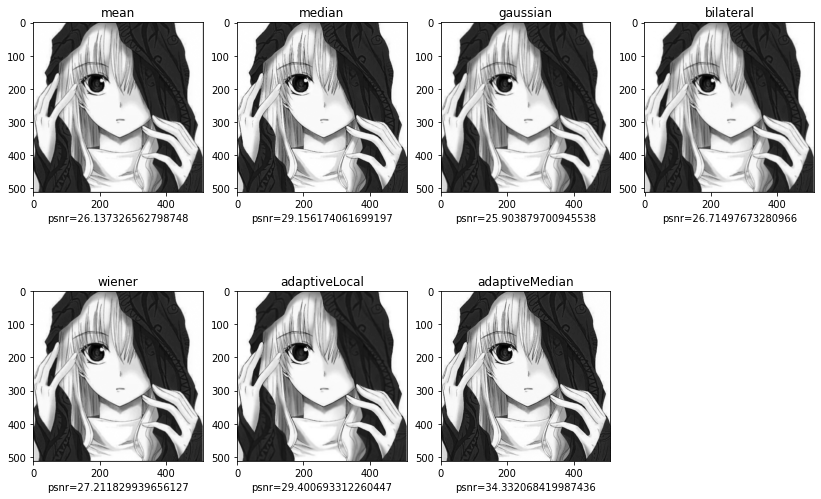

In [45]:
showImg(imgOr,x,y,3)

In [46]:
imgOr=plt.imread('img5.png')
blur=cv2.blur(imgOr,(7,7))

imgOr = cv2.normalize(imgOr, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
imgOr = imgOr.astype(np.float32)


The signal to noise ratio of image with s&p noise is 21.102465255982583
The signal to noise ratio of denoised image using mean filter is 25.146849539318133
The signal to noise ratio of denoised image using median filter is 30.151819212004312
The signal to noise ratio of denoised image using gaussian filter is 25.327411704169673
The signal to noise ratio of denoised image using bilateral filter is 26.1063260563502


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using wiener filter is 25.90671813571006
The signal to noise ratio of denoised image using adaptiveLocal filter is 24.37316609737374
The signal to noise ratio of denoised image using adaptiveMedian filter is 33.262686047291375


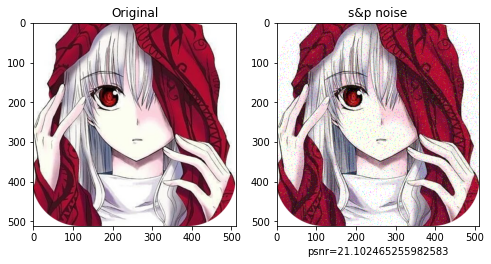

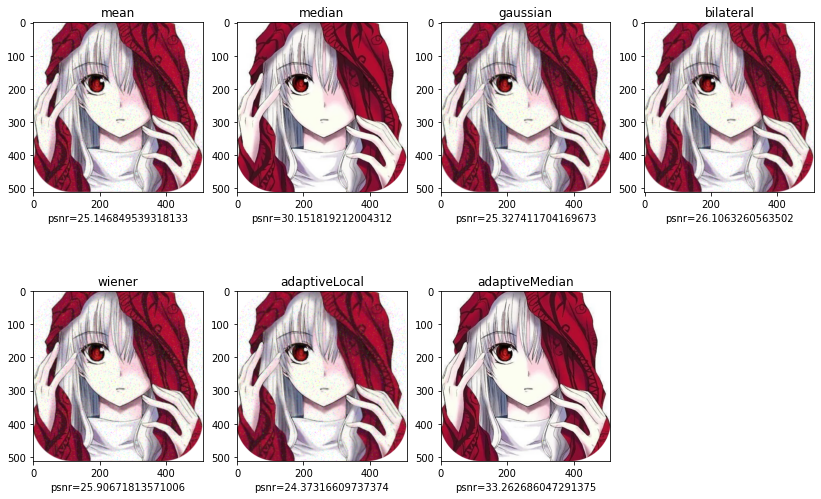

In [47]:
showImg(imgOr,x,y,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of image with gauss noise is 20.008090407115596


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using mean filter is 25.01881427762274


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using median filter is 25.34682975563689


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using gaussian filter is 25.309421999579072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using bilateral filter is 25.999634821329117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using wiener filter is 25.829917300027535


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using adaptiveLocal filter is 26.689597417568194


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using adaptiveMedian filter is 22.614683389987142


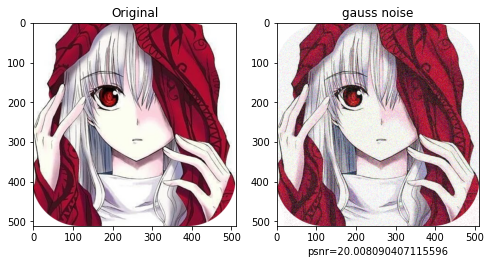

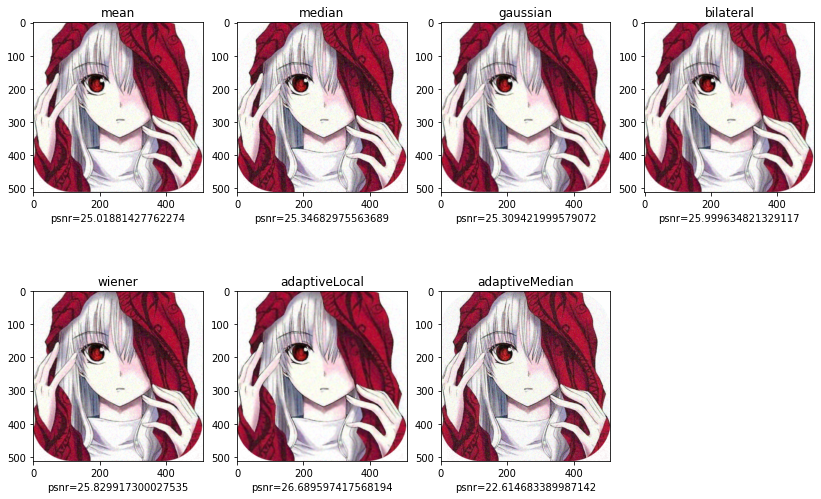

In [48]:
showImg(imgOr,x,y,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of image with speckle noise is 22.089959152532042


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using mean filter is 25.639414013871566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using median filter is 26.714501496830604


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using gaussian filter is 25.79266041959912


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using bilateral filter is 26.548160460469017


C:\Users\ANUHYA\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
C:\Users\ANUHYA\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\signaltools.py:1598: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using wiener filter is 26.5672678466013


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using adaptiveLocal filter is 27.84057203761918


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using adaptiveMedian filter is 24.60656499341755


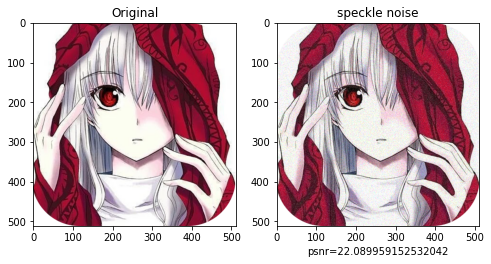

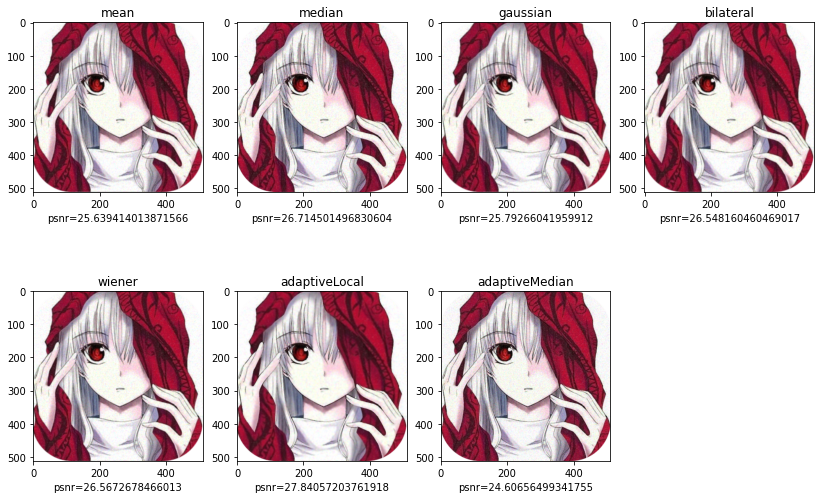

In [49]:
showImg(imgOr,x,y,2)

In [50]:
showImg(imgOr,x,y,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of image with poisson noise is 25.619581813010033


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The signal to noise ratio of denoised image using mean filter is 26.296514173020455
